# Training a basic NLP classifier for IHCC mapping using scikit learn

In this notebook we implement a very basic NLP pipeline that uses a Support Vector Machine to classify data dictionary terms into GECKO categories.

In [1]:
class YClass( object ):
    pass

args = YClass()
setattr(args,'config_file','/Users/matentzn/knocean/data-harmonization/src/mapping-suggest/mapping-suggest-config.yml')
setattr(args,'validation_data_file','/Users/matentzn/knocean/data-harmonization/build/intermediate/koges-xrefs-sparql.csv')
setattr(args,'validation_data_template_file','/Users/matentzn/knocean/data-harmonization/templates/koges.tsv')
setattr(args,'training_data_file','/Users/matentzn/knocean/data-harmonization/data/ihcc-mapping-suggestions-zooma-basic.tsv')
setattr(args,'prediction_results','/Users/matentzn/knocean/data-harmonization/templates/_koges_nlp.tsv')
setattr(args,'gecko_file','/Users/matentzn/knocean/data-harmonization/build/intermediate/gecko-xrefs-sparql.csv')


In [2]:
import os
import pandas as pd
import re
from datetime import datetime
import csv
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report
from gensim.parsing.porter import PorterStemmer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer


from lib import compute_string_variants, print_accuracy_results, obo_id_to_iri, obo_purl

# Loading the data

In [3]:
data=pd.read_csv(args.training_data_file,sep="\t")
data

,STUDY,BIOENTITY,PROPERTY_TYPE,PROPERTY_VALUE,SEMANTIC_TAG,ANNOTATOR,ANNOTATION_DATE
0,IHCC Basic,https://purl.ihccglobal.org/KoGES_0000078,information_entity,Blood,http://purl.obolibrary.org/obo/UBERON_0001088,Knocean,2020-09-07 18:36:33
1,IHCC Basic,https://purl.ihccglobal.org/KoGES_0000147,information_entity,Vitamin B12,http://purl.obolibrary.org/obo/UBERON_0000178,Knocean,2020-09-07 18:36:33
2,IHCC Basic,https://purl.ihccglobal.org/KoGES_0000002,information_entity,Core Questionnaires,http://purl.obolibrary.org/obo/GECKO_0000056,Knocean,2020-09-07 18:36:33
3,IHCC Basic,https://purl.ihccglobal.org/KoGES_0000174,information_entity,HPV(Human Papillomavirus),http://purl.obolibrary.org/obo/UBERON_0000178,Knocean,2020-09-07 18:36:33
4,IHCC Basic,https://purl.ihccglobal.org/KoGES_0000142,information_entity,Eosinophil,http://purl.obolibrary.org/obo/UBERON_0000178,Knocean,2020-09-07 18:36:33
...,...,...,...,...,...,...,...
2748,IHCC Basic,http://purl.obolibrary.org/obo/OBI_0000435,information_entity,DNA/Genotyping,http://purl.obolibrary.org/obo/OBI_0000435,Knocean,2020-09-07 18:36:33
2749,IHCC Basic,http://purl.obolibrary.org/obo/GECKO_0000067,information_entity,lifestyle and behaviours,http://purl.obolibrary.org/obo/GECKO_0000067,Knocean,2020-09-07 18:36:33
2750,IHCC Basic,http://purl.obolibrary.org/obo/UBERON_0001088,information_entity,urine,http://purl.obolibrary.org/obo/UBERON_0001088,Knocean,2020-09-07 18:36:33
2751,IHCC Basic,http://purl.obolibrary.org/obo/CMO_0000294,information_entity,heart rate (HR),http://purl.obolibrary.org/obo/CMO_0000294,Knocean,2020-09-07 18:36:33


In [4]:
gecko=pd.read_csv(args.gecko_file,sep=",")
gecko_labels=gecko[gecko['property']=="http://www.w3.org/2000/01/rdf-schema#label"][['from','label']]
gecko=gecko[['from','label']]
gecko

,from,label
0,http://purl.obolibrary.org/obo/GECKO_0000071,sleep
1,http://purl.obolibrary.org/obo/GECKO_0000094,associated disease(s)
2,http://purl.obolibrary.org/obo/OBI_0002118,WES
3,http://purl.obolibrary.org/obo/OBI_0000537,"Sequence variants (CNV, SNP arrays)"
4,http://purl.obolibrary.org/obo/GECKO_0000010,sex(es) studied in cohort
...,...,...
83,http://purl.obolibrary.org/obo/OBI_0000435,DNA/Genotyping
84,http://purl.obolibrary.org/obo/GECKO_0000067,lifestyle and behaviours
85,http://purl.obolibrary.org/obo/UBERON_0001088,urine
86,http://purl.obolibrary.org/obo/CMO_0000294,heart rate (HR)


In [5]:
X = data['PROPERTY_VALUE'].tolist()
y = data['SEMANTIC_TAG'].tolist()

In [6]:
# Modification 1, adding GECKO metadata to augment training data. 
X.extend(gecko['label'].tolist())
y.extend(gecko['from'].tolist())
raw_data = pd.DataFrame(
    {'X': X,
     'y': y
    })
raw_data=raw_data.drop_duplicates()

# Raw data exploration

In [7]:
raw_data.describe()

,X,y
count,2608,2608
unique,2545,88
top,Date (Death),http://purl.obolibrary.org/obo/GECKO_0000052
freq,2,485


In [8]:
raw_data['X'].value_counts().describe()

count    2545.000000
mean        1.024754
std         0.155406
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         2.000000
Name: X, dtype: float64

In [9]:
#raw_data_sub=raw_data.groupby("y").filter(lambda x: len(x) > 10)
#raw_data = raw_data_sub
#raw_data_sub

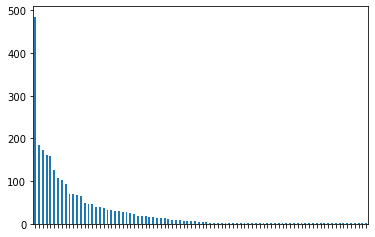

In [10]:
# Matplotlib for additional customization
from matplotlib import pyplot as plt
%matplotlib inline

fig, ax = plt.subplots()
raw_data['y'].value_counts().plot(ax=ax, kind='bar')
ax.tick_params(labelbottom=False)    

plt.show()

# Data preparation

In [11]:
df = raw_data
df['X_pre'] = df['X'].apply(lambda x: compute_string_variants(x))

with open("raw_data.tsv",'w') as write_csv:
    write_csv.write(df.sort_values('y').to_csv(sep='\t', index=False))

df

,X,y,X_pre
0,Blood,http://purl.obolibrary.org/obo/UBERON_0001088,Blood
1,Vitamin B12,http://purl.obolibrary.org/obo/UBERON_0000178,Vitamin B 12
2,Core Questionnaires,http://purl.obolibrary.org/obo/GECKO_0000056,Core Questionnaires
3,HPV(Human Papillomavirus),http://purl.obolibrary.org/obo/UBERON_0000178,HPV Human Papillomavirus
4,Eosinophil,http://purl.obolibrary.org/obo/UBERON_0000178,Eosinophil
...,...,...,...
2748,DNA/Genotyping,http://purl.obolibrary.org/obo/OBI_0000435,DNA Genotyping
2749,lifestyle and behaviours,http://purl.obolibrary.org/obo/GECKO_0000067,lifestyle and behaviours
2750,urine,http://purl.obolibrary.org/obo/UBERON_0001088,urine
2751,heart rate (HR),http://purl.obolibrary.org/obo/CMO_0000294,heart rate HR


# Training the model

In [12]:
X=df['X']
y=df['y']

###### Stemming

p = PorterStemmer()

for i in range(len(X)):
    X.iloc[i] = p.stem_sentence(X.iloc[i])

In [13]:
# removed stratify =y because of lots classes with only a single member
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

In [14]:
X_train[:5]

190               Anti-microsomal Ab
1815                         Q2-VV11
1552                          Q1-HR7
943                        Age Bands
1630    SUS generated Core Spell HRG
Name: X, dtype: object

In [15]:
X_test[:5]

788                                      invest2_06
117     Previous diagnosis (Family disease history)
168                                Apolipoprotein B
2641       Medical Officer Suggested Second Outcome
1164                             EPISODE MATCH RANK
Name: X, dtype: object

In [16]:
y_test[:5]

788        http://purl.obolibrary.org/obo/CMO_0000000
117      http://purl.obolibrary.org/obo/MONDO_0000001
168     http://purl.obolibrary.org/obo/UBERON_0000178
2641     http://purl.obolibrary.org/obo/GECKO_0000052
1164     http://purl.obolibrary.org/obo/GECKO_0000052
Name: y, dtype: object

In [17]:
y_train[:5]

190     http://purl.obolibrary.org/obo/UBERON_0000178
1815      http://purl.obolibrary.org/obo/OGMS_0000020
1552      http://purl.obolibrary.org/obo/OGMS_0000020
943       http://purl.obolibrary.org/obo/PATO_0000011
1630     http://purl.obolibrary.org/obo/GECKO_0000052
Name: y, dtype: object

### Preprocessing: CountVectorizer

In [18]:
count_vect = CountVectorizer(ngram_range = (1,2), stop_words = 'english', min_df = 2).fit(X_train) 
X_train_counts = count_vect.transform(X_train)

#### Analyse CountVectorizer vocabulary

In [19]:
#Get the most frequent words
vocabulary = count_vect.vocabulary_
sum_words = X_train_counts.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in vocabulary.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
print(words_freq[:20])
print(words_freq[-10:])

[('medical', 55), ('date', 55), ('officer', 54), ('medical officer', 54), ('lung', 41), ('medication', 40), ('diagnostic', 37), ('q1', 32), ('radiologist', 28), ('q2', 27), ('blood', 26), ('care', 23), ('number', 23), ('test', 23), ('code', 22), ('concurrent', 21), ('concurrent medication', 21), ('treatment', 21), ('age', 20), ('left', 20)]
[('intake', 2), ('employed', 2), ('age baby', 2), ('baby days', 2), ('social support', 2), ('history stroke', 2), ('district residence', 2), ('month', 2), ('heart disease', 2), ('activities', 2)]


### Preprocessing: TFIDF

In [20]:
tfidf_vect = TfidfVectorizer(ngram_range = (1,2), min_df = 2).fit(X_train)
X_train_tfidf = tfidf_vect.transform(X_train)

## Classification
### Naive Bayes (with Bag of words)

In [21]:
clf = MultinomialNB(alpha = 0.1).fit(X_train_counts, y_train)
X_test_counts = count_vect.transform(X_test)
y_pred  = clf.predict(X_test_counts)
print_accuracy_results(y_test,y_pred)

Overall accuracy : 0.42911877394636017
F1 micro : 0.42911877394636017
F1 macro : 0.26486314531355165
F1 for each class : [0.84848485 0.71428571 0.         0.         0.         0.66666667
 0.         0.4        0.         0.         0.         0.16666667
 0.         0.         0.         0.         0.42396313 0.33333333
 0.         0.         0.66666667 0.         0.32       1.
 0.28571429 0.4        0.8        0.66666667 0.28571429 0.66666667
 0.         0.15384615 0.8        0.33333333 0.         0.25
 0.6        0.11111111 0.3        0.         0.         0.8
 0.         0.5        0.         0.         0.         0.72413793
 0.88888889 0.         0.3        0.         0.         0.41269841
 0.         0.36363636 0.         0.44444444 0.        ]


### Naive Bayes (with TFIDF)

In [22]:
clf2 = MultinomialNB(alpha = 0.1).fit(X_train_tfidf, y_train)
X_test_tfidf = tfidf_vect.transform(X_test)
y_pred  = clf2.predict(X_test_tfidf)
print_accuracy_results(y_test,y_pred)

Overall accuracy : 0.41762452107279696
F1 micro : 0.417624521072797
F1 macro : 0.21358786737418406
F1 for each class : [0.84848485 0.71428571 0.         0.         0.         0.8
 0.         0.5        0.         0.         0.         0.18181818
 0.         0.         0.         0.         0.43111111 0.18181818
 0.         0.         0.66666667 0.         0.26086957 0.
 0.         0.22222222 0.8        0.66666667 0.30769231 0.4
 0.28571429 0.8        0.         0.         0.25       0.57142857
 0.09090909 0.29268293 0.         0.         0.         0.
 0.33333333 0.         0.         0.         0.71186441 0.57142857
 0.         0.27272727 0.         0.         0.41935484 0.
 0.47368421 0.         0.33333333 0.        ]


### SVM classifier (with TFIDF and linear with stochastic gradient descent for faster computation)

In [33]:
clf_svg = SGDClassifier(loss='hinge', penalty='l2', alpha = 1e-05).fit(X_train_tfidf,y_train)
y_pred_svg  = clf_svg.predict(X_test_tfidf)
print_accuracy_results(y_test,y_pred_svg)

Overall accuracy : 0.43103448275862066
F1 micro : 0.43103448275862066
F1 macro : 0.2860069762037563
F1 for each class : [0.84848485 0.         0.71428571 1.         0.         0.
 0.66666667 0.         0.         0.58823529 0.         0.
 0.         0.18181818 0.         0.         0.         0.
 0.         0.43230404 0.58823529 0.         0.         0.66666667
 0.         0.36363636 1.         0.25       0.         0.2
 0.71428571 0.4        0.28571429 0.5        0.         0.15384615
 0.75862069 0.57142857 0.         0.25       0.88888889 0.
 0.08695652 0.22857143 0.66666667 0.22222222 0.8        1.
 0.5        0.4        0.         0.         0.         0.77777778
 0.25       0.         0.27027027 0.         0.         0.39344262
 0.         0.4        0.         0.57142857 0.        ]


In [24]:
def tb_right_wrong(X,y,y_pred):
    df = pd.DataFrame(
    {'X': X,
     'y': y,
     'y_pred': y_pred
    })
    df['correct'] = df['y']==df['y_pred']
    
    return df[df['correct']], df[~df['correct']]

df_right, df_wrong = tb_right_wrong(X_test,y_test,y_pred_svg)
df_wrong

,X,y,y_pred,correct
788,invest2_06,http://purl.obolibrary.org/obo/CMO_0000000,http://purl.obolibrary.org/obo/GECKO_0000068,False
168,Apolipoprotein B,http://purl.obolibrary.org/obo/UBERON_0000178,http://purl.obolibrary.org/obo/GECKO_0000068,False
1164,EPISODE MATCH RANK,http://purl.obolibrary.org/obo/GECKO_0000052,http://purl.obolibrary.org/obo/STATO_0000093,False
1591,mhd_honos_honosrating5_score,http://purl.obolibrary.org/obo/GECKO_0000052,http://purl.obolibrary.org/obo/GECKO_0000068,False
2234,Hypertension,http://purl.obolibrary.org/obo/MONDO_0000001,http://purl.obolibrary.org/obo/GECKO_0000093,False
...,...,...,...,...
819,mhd_honoscarating6_score,http://purl.obolibrary.org/obo/GECKO_0000052,http://purl.obolibrary.org/obo/GECKO_0000068,False
1215,Commissioner's Regional Office,http://purl.obolibrary.org/obo/GECKO_0000052,http://purl.obolibrary.org/obo/GECKO_0000064,False
1029,High-dependency care level,http://purl.obolibrary.org/obo/STATO_0000093,http://purl.obolibrary.org/obo/OGMS_0000020,False
2709,genomics,http://purl.obolibrary.org/obo/GECKO_0000032,http://purl.obolibrary.org/obo/GECKO_0000068,False


In [25]:
print(classification_report(y_test, y_pred_svg))

                                               precision    recall  f1-score   support

   http://purl.obolibrary.org/obo/CMO_0000000       1.00      0.74      0.85        19
   http://purl.obolibrary.org/obo/CMO_0000001       0.00      0.00      0.00         0
   http://purl.obolibrary.org/obo/CMO_0000003       0.83      0.56      0.67         9
   http://purl.obolibrary.org/obo/CMO_0000012       1.00      1.00      1.00         1
   http://purl.obolibrary.org/obo/CMO_0000021       0.00      0.00      0.00         2
   http://purl.obolibrary.org/obo/CMO_0000106       0.00      0.00      0.00         1
   http://purl.obolibrary.org/obo/CMO_0000294       0.50      0.67      0.57         3
 http://purl.obolibrary.org/obo/GECKO_0000003       0.00      0.00      0.00         1
 http://purl.obolibrary.org/obo/GECKO_0000005       0.00      0.00      0.00         0
 http://purl.obolibrary.org/obo/GECKO_0000006       0.71      0.50      0.59        10
 http://purl.obolibrary.org/obo/GECKO_0000

/Users/matentzn/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/matentzn/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Using a pipeline with SVM, TFIDF

In [26]:
tfidf_transform = TfidfTransformer()

pipeline_svm = Pipeline([('bow', CountVectorizer(ngram_range = (1,2), stop_words = 'english', min_df = 2)),
                         ('tfidf', tfidf_transform),
                         ('clf_svg', SGDClassifier(loss='hinge', penalty='l2', alpha = 1e-05))])

#pipeline_svm = Pipeline([('bow', count_vectorize),('tfidf', tfidf_transform),('clf_svm', SVC(kernel = 'rbf'))])

clf_stem = pipeline_svm.fit(X_train, y_train)
y_pred_stem  = clf_stem.predict(X_test)
print_accuracy_results(y_test,y_pred_stem)

Overall accuracy : 0.4386973180076628
F1 micro : 0.4386973180076628
F1 macro : 0.3101865800616376
F1 for each class : [0.84848485 0.         0.71428571 1.         0.         0.
 0.57142857 0.         0.4        0.         0.         0.
 0.16666667 0.         0.         0.         0.         0.44186047
 0.47058824 0.         0.         0.66666667 0.         0.30769231
 1.         0.28571429 0.4        0.8        0.25       0.16666667
 0.72727273 0.         0.15384615 0.8        0.57142857 0.
 0.25       0.88888889 0.08695652 0.28571429 0.66666667 0.
 0.5        1.         0.5        0.         1.         0.
 0.81481481 0.         0.         0.31578947 0.         0.
 0.33898305 0.28571429 0.36363636 0.         0.57142857 0.        ]


# Validating against test data

In [27]:
tsv=pd.read_csv(args.validation_data_file,sep=",")
template=pd.read_csv(args.validation_data_template_file,sep="\t")

template['IRI']=["https://purl.ihccglobal.org/"+str(item).replace(":","_") for item in template['Term ID']]
del template['Suggested Categories']
template=pd.merge(template, tsv[['from','to']], how='left', left_on=['IRI'], right_on=['from'])
template

,Term ID,Label,Parent Term,Definition,GECKO Category,Comment,IRI,from,to
0,ID,LABEL,C % SPLIT=|,A definition,NaN,NaN,https://purl.ihccglobal.org/ID,NaN,NaN
1,NaN,is-required;,NaN,NaN,NaN,NaN,https://purl.ihccglobal.org/nan,NaN,NaN
2,KoGES:0000001,Core Variables,NaN,NaN,NaN,NaN,https://purl.ihccglobal.org/KoGES_0000001,NaN,NaN
3,KoGES:0000002,Core Questionnaires,KoGES:0000001,NaN,questionnaire/survey data,NaN,https://purl.ihccglobal.org/KoGES_0000002,https://purl.ihccglobal.org/KoGES_0000002,GECKO:0000056
4,KoGES:0000003,Socio-demographic data,KoGES:0000002,NaN,socio-demographic and economic characteristics,NaN,https://purl.ihccglobal.org/KoGES_0000003,https://purl.ihccglobal.org/KoGES_0000003,PATO:0001995
...,...,...,...,...,...,...,...,...,...
204,KoGES:0000204,Calcium (Urine),KoGES:0000187,NaN,urine,NaN,https://purl.ihccglobal.org/KoGES_0000204,https://purl.ihccglobal.org/KoGES_0000204,UBERON:0001088
205,KoGES:0000205,Sodium (Urine),KoGES:0000187,NaN,urine,NaN,https://purl.ihccglobal.org/KoGES_0000205,https://purl.ihccglobal.org/KoGES_0000205,UBERON:0001088
206,KoGES:0000206,Potassium (Urine),KoGES:0000187,NaN,urine,NaN,https://purl.ihccglobal.org/KoGES_0000206,https://purl.ihccglobal.org/KoGES_0000206,UBERON:0001088
207,KoGES:0000207,Vitamin C,KoGES:0000187,NaN,urine,no CMO term for vit C levels in urine,https://purl.ihccglobal.org/KoGES_0000207,https://purl.ihccglobal.org/KoGES_0000207,UBERON:0001088


In [28]:
tx=template[['Label','to']].copy()
tx['to']=[obo_id_to_iri(item) for item in template['to']]
tx=tx.dropna()
X_validate=tx['Label'].values
y_validate=tx['to'].values

tx

Warning, nan is no string!
Warning, nan is no string!
Warning, nan is no string!
Warning, nan is no string!
Warning, nan is no string!
Warning, nan is no string!
Warning, nan is no string!
Warning, nan is no string!
Warning, nan is no string!


,Label,to
3,Core Questionnaires,http://purl.obolibrary.org/obo/GECKO_0000056
4,Socio-demographic data,http://purl.obolibrary.org/obo/PATO_0001995
5,Education level,http://purl.obolibrary.org/obo/GECKO_0000065
6,Marital status,http://purl.obolibrary.org/obo/PATO_0001995
7,Household income,http://purl.obolibrary.org/obo/PATO_0001995
...,...,...
204,Calcium (Urine),http://purl.obolibrary.org/obo/UBERON_0001088
205,Sodium (Urine),http://purl.obolibrary.org/obo/UBERON_0001088
206,Potassium (Urine),http://purl.obolibrary.org/obo/UBERON_0001088
207,Vitamin C,http://purl.obolibrary.org/obo/UBERON_0001088


In [29]:
tfidf_validate = tfidf_vect.transform(X_validate)
pred_validate  = clf_svg.predict(tfidf_validate)
print_accuracy_results(y_validate,pred_validate)

Overall accuracy : 0.56
F1 micro : 0.56
F1 macro : 0.5824209855650019
F1 for each class : [0.8        0.         0.         0.8        0.         0.66666667
 0.         0.85714286 1.         0.         0.66666667 0.11764706
 1.         0.66666667 1.         1.         1.         0.75
 0.88888889 0.85714286 0.         0.90909091 1.         1.
 0.85714286 0.         0.56666667 0.48648649 0.        ]


### Exporting test data

In [30]:
df_out = pd.DataFrame(
    {'Label': X_validate,
     'Suggested Categories': pred_validate
    })
df_out=pd.merge(df_out, gecko_labels, how='left', left_on=['Suggested Categories'], right_on=['from'])
df_out['Suggested Categories']=[str(item).replace(obo_purl,"").replace("_",":") if item.startswith(obo_purl) else item for item in df_out['Suggested Categories']]
df_out['Suggested Categories']="MEDIUM "+df_out['Suggested Categories']+" "+df_out['label']
del df_out['from']
del df_out['label']
df_out

,Label,Suggested Categories
0,Core Questionnaires,MEDIUM GECKO:0000056 questionnaire/survey data
1,Socio-demographic data,MEDIUM PATO:0001995 socio-demographic and econ...
2,Education level,MEDIUM GECKO:0000065 education
3,Marital status,MEDIUM PATO:0001995 socio-demographic and econ...
4,Household income,MEDIUM PATO:0001995 socio-demographic and econ...
...,...,...
195,Calcium (Urine),MEDIUM UBERON:0001088 urine
196,Sodium (Urine),MEDIUM UBERON:0001088 urine
197,Potassium (Urine),MEDIUM UBERON:0001088 urine
198,Vitamin C,MEDIUM UBERON:0000178 blood


In [31]:
template_out=pd.merge(template, df_out.drop_duplicates(), how='left', left_on=['Label'], right_on=['Label'])
template_out=template_out[['Term ID','Label','Parent Term','Definition','Comment','Suggested Categories']]
template_out=template_out.drop_duplicates()
template_out

,Term ID,Label,Parent Term,Definition,Comment,Suggested Categories
0,ID,LABEL,C % SPLIT=|,A definition,NaN,NaN
1,NaN,is-required;,NaN,NaN,NaN,NaN
2,KoGES:0000001,Core Variables,NaN,NaN,NaN,NaN
3,KoGES:0000002,Core Questionnaires,KoGES:0000001,NaN,NaN,MEDIUM GECKO:0000056 questionnaire/survey data
4,KoGES:0000003,Socio-demographic data,KoGES:0000002,NaN,NaN,MEDIUM PATO:0001995 socio-demographic and econ...
...,...,...,...,...,...,...
204,KoGES:0000204,Calcium (Urine),KoGES:0000187,NaN,NaN,MEDIUM UBERON:0001088 urine
205,KoGES:0000205,Sodium (Urine),KoGES:0000187,NaN,NaN,MEDIUM UBERON:0001088 urine
206,KoGES:0000206,Potassium (Urine),KoGES:0000187,NaN,NaN,MEDIUM UBERON:0001088 urine
207,KoGES:0000207,Vitamin C,KoGES:0000187,NaN,no CMO term for vit C levels in urine,MEDIUM UBERON:0000178 blood


In [32]:
with open(args.prediction_results,'w') as write_csv:
    write_csv.write(template_out.to_csv(sep='\t', index=False))